# Programming Exercise 5: Regularized Linear Regression and Bias v.s. Variance

In this exercise, you will implement regularized linear regression and use it to study models with different vias-variance properties.

## 1. Regularized Linear Regression
In the first half of the exercise, you will implement regularized linear regression to predict the amount of water flowing out of  adam using the change of water level in a reservoir. In the next half, you will go through some diagnostics of debugging learning algorithms and examine the effects of bias v.s. variance

### 1.1 Visualizing the dataset
We begin by visualizing the dataset containing historical records on the change in the water level, x, and the amount of water flowing out of the dam, y.

The dataset is divided into three parts:
- A training set that your modle will learn on: X, y
- A cross validation set for determining the regularization parameter: Xval, yval
- A test set for evaluating performance. These are 'unseen' examples which your model did not observe during training: Xtest, ytest

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

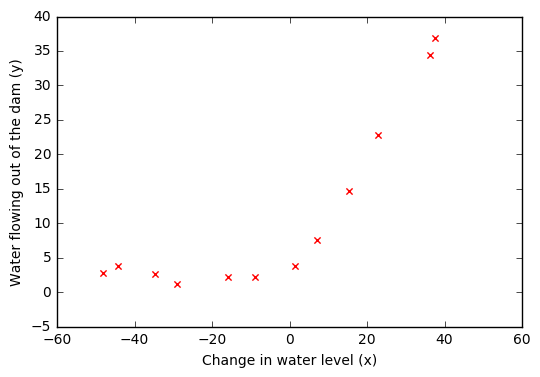

In [108]:
import scipy.io
datamatrix = scipy.io.loadmat('/Users/tess/Desktop/MachineLearning/machine-learning-ex5/ex5/ex5data1.mat')

X, y = datamatrix['X'], datamatrix['y']                 # training data
Xval, yval = datamatrix['Xval'], datamatrix['yval']     # cross-validation data
Xtest, ytest = datamatrix['Xtest'], datamatrix['ytest'] # testing data

plt.scatter(X,y, marker = 'x', c= 'red')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

### 1.2 Regularized linear regression cost function
### 1.3 Regularized linear regression gradient

First, let's try to fit a straight line to the data

In [109]:
X = np.insert(X, 0, 1, axis = 1)  # insert a row of 1's for theta0
theta = np.array([[1.], [1.]])

X.shape, y.shape, theta.shape

((12, 2), (12, 1), (2, 1))

In [148]:
def linearRegCostFunction(theta, X, y, lamb):
    
    m = y.size                  # number of training examples
    h = np.dot(X, theta)        # linear hypothesis 

    J = (1/(2.*m))*np.sum(np.square(h-y)) + (lamb/(2.*m))*np.sum(np.square(theta[1:]))
    return J

In [160]:
def linearRegGradient(theta, X, y, lamb):
    theta = theta.reshape(-1,1)

    m = y.size
    h = np.dot(X, theta)
    grad = (1./m) * np.dot(X.T, (h - y)) + (lamb/(float(m)))*np.r_[[[0]],theta[1:].reshape(-1,1)]    
    return grad.flatten()

In [161]:
# using theta initalized at [1; 1], should expect to see J = 303.993
# and should see a gradient of [-15.30; 598.250]
cost = linearRegCostFunction(theta, X, y, 1)
grad = linearRegGradient(theta, X, y, 1)
cost, grad

(303.99319222026429, array([ -15.30301567,  598.25074417]))

### 1.4 Fitting linear regression

Compute the optimal values of theta. We will use scipy's optimize_fmin_cg to optimize the cost function.

In this part, we set the regularization parameter lambda to zero. Because our current implementation of linear regression is trying to fit a 2-dimensional theta, regularization will not be incredibly helpful for a theta of such low dimension. 

In [215]:
import scipy

def trainLinearReg(theta, X, y, lamb):
    initial_theta = np.array([[1.],[1.],[1.],[1.],[1.],[1.],[1.],[1.],[1.]])
    #initial_theta = np.array([[30],[30]])

    results = scipy.optimize.minimize(linearRegCostFunction, initial_theta,  \
                                     args=(X, y, lamb), method = None, \
                                      jac = linearRegGradient,\
                                      options = {'maxiter':5000})
    return results

#theta_opt = trainLinearReg(theta, X, y, 0)
#theta_opt

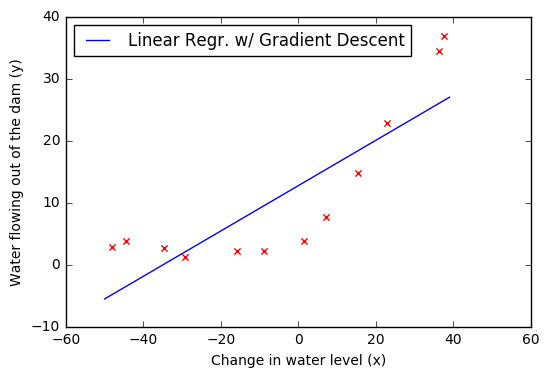

In [84]:
# plot line of best fit:
x_fit = np.arange(-50, 40)
y_fit = theta_opt[0][0] + theta_opt[0][1]*x_fit

X_plt = X[:,1:] # remove row of 1's for plotting

plt.scatter(X_plt,y, marker = 'x', c= 'red')
plt.plot(x_fit, y_fit, label = 'Linear Regr. w/ Gradient Descent')
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.legend(loc = 2)

## 2. Bias-variance

An important concept in machine learning is the bias-variance tradeoff. Models with high bias are not complex enough for the data and tend to underfit, while models with high variance overfit to the training data.

In this part of the exercise, you will plot training and test errors on a learning curve to diagnose bias-variance problems

### 2.1 Learning curves
A learning curve plots training and cross validation error as a function of the training set size. 

In [110]:
Xval = np.insert(Xval, 0, 1, axis = 1)  # insert a row of 1's for theta0

In [170]:
# return a vector of errors for the training set and cross validation set

def learningCurve(Xtrain, ytrain, Xval, yval):

    m = Xtrain.shape[0]
    error_train = []
    error_val = []
    for i in range(1,m+1):
        subsetX = Xtrain[:i, :]
        subsety = ytrain[:i]
        theta = np.array([[1.], [1.]])
        
        # train on a subset of the data:
        theta_opt = trainLinearReg_2(theta, subsetX, subsety, 0) # find thetas
        # calculate error for train and validation data
        error_train.append(linearRegCostFunction(theta_opt.x, subsetX, subsety, 0))
        error_val.append(linearRegCostFunction(theta_opt.x, Xval, yval, 0))
    return error_train, error_val

error_train, error_val = learningCurve(X, y, Xval, yval)

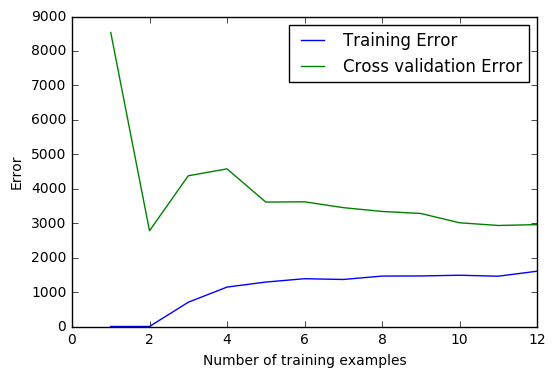

In [177]:
# plot the learning curve
# note: since the model is underfitting the data, we expect to see a graph with high bias
m = X.shape[0]
size = range(1,m+1)
plt.plot(size, error_train, label = "Training Error")
plt.plot(size, error_val, c = 'green', label = "Cross validation Error")
plt.legend(loc = 1)
plt.xlabel('Number of training examples')
plt.ylabel('Error')

## 3. Polynomial regression
The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias). In this part of the exercise, you will address this problem by adding more features.

In [199]:
# when a training set X of size m x 1 is passed, return an m x p matrix
# where column 1 holds the original values of X, column 2 holds the values
# of X**2, column 3 holds the values of X**3, etc.
def polyFeatures(X, degree):
    m = X.shape[0]
    #X_poly = np.array((m,degree))
    X_poly = X
    X_poly.shape
    for i in range(2, degree+1):
        poly = np.power(X, i)
        X_poly = np.append(X_poly, poly, axis = 1)
    
    return X_poly

X_poly = polyFeatures(X[:,1:], 8)
X_poly.shape

(12, 8)

### 3.1 Learning Polynomial Regression

For this part of the exercise, you will be using a polynomial of degree 8. It turns out that running the training directly on the projected data does not work well as the features would be badly scaled (e.g. an example with x = 40 will now have a feature x(8) = 40^8 = 6.5 x 10^12! Therefore, you will need to use feature normalization.

In [206]:
# normalizes the features in X. 
# returns a normalized version of X where the mean value of each feature
# is 0 and the standard deviation is 1.

def featureNorm(X):
    
    normX = X
    means = np.mean(normX,axis=0) #column-by-column
    normX = normX - means
    stds = np.std(normX,axis=0,ddof=1)
    normX = normX / stds
    
    return normX, means, stds

In [208]:
# map onto polynomial = 8 space
X_poly = polyFeatures(X[:,1:], 8)
X_poly_val = polyFeatures(Xval[:,1:], 8)
X_poly_test = polyFeatures(Xtest[:,1:], 8)

# normalize features:
X_poly, X_poly_means, X_poly_stds = featureNorm(X_poly)
X_poly_val, X_poly_val_means, X_poly_val_stds = featureNorm(X_poly_val)
X_poly_test, X_poly__test_means, X_poly__test_stds = featureNorm(X_poly_test)

# add column of 1's
X_poly = np.insert(X_poly, 0, 1, axis = 1)
X_poly_val = np.insert(X_poly_val, 0, 1, axis = 1)
X_poly_test = np.insert(X_poly_test, 0, 1, axis = 1)

In [216]:
lamb = 0
theta_poly_opt = trainLinearReg(theta, X_poly, y, lamb)

In [217]:
theta_poly_opt

      fun: 1402.0987486322988
 hess_inv: array([[  1.00388531e+00,   2.07224560e-02,  -9.23132850e-04,
         -1.05710318e-02,  -9.40379724e-03,  -1.29566789e-02,
         -8.43744057e-03,  -8.76151963e-03,  -6.93347390e-03],
       [  2.07224560e-02,   9.54448849e-01,   8.09692410e-02,
         -8.17331679e-02,   8.36007092e-02,  -9.11663662e-02,
          8.57105688e-02,  -9.17989074e-02,   8.59788708e-02],
       [ -9.23132850e-04,   8.09692410e-02,   9.16388780e-01,
          8.63096486e-02,  -9.68858097e-02,   9.16774211e-02,
         -9.96959489e-02,   9.47574005e-02,  -9.94584025e-02],
       [ -1.05710318e-02,  -8.17331679e-02,   8.63096486e-02,
          8.91210498e-01,   9.60464248e-02,  -1.14395543e-01,
          1.01053058e-01,  -1.13146137e-01,   1.02716495e-01],
       [ -9.40379724e-03,   8.36007092e-02,  -9.68858097e-02,
          9.60464248e-02,   8.90332205e-01,   1.03613752e-01,
         -1.12367282e-01,   1.07187398e-01,  -1.11924980e-01],
       [ -1.29566789e-02

In [1]:
### not currently working. will return later.

def plotFit(fit_theta,means,stds):
   
    n_points_to_plot = 50
    xvals = np.linspace(-55,55,n_points_to_plot)
    xmat = np.ones((n_points_to_plot,1))
    
    xmat = np.insert(xmat,xmat.shape[1],xvals.T,axis=1)
    xmat = polyFeatures(xmat,len(fit_theta)-2)
    xmat[:,1:] = xmat[:,1:] - means[1:]
    xmat[:,1:] = xmat[:,1:] / stds[1:]
    plotData()
    plt.plot(xvals,h(fit_theta,xmat),'b--')

plotFit(theta_poly_opt.x,X_poly_means,X_poly_stds)

NameError: name 'theta_poly_opt' is not defined